In [44]:
import pandas as pd
import numpy as np
import glob
import re
from bs4 import BeautifulSoup 
from nltk import tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import NMF

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt

In [18]:
tags_df = pd.read_csv('Interview_Mapping.csv')

In [19]:
tags_df

,Judgements,Area.of.Law
0,LNIND_1988_CAL_114,To be Tested
1,LNIND_1956_CAL_163,To be Tested
2,LNIND_1976_CAL_277,To be Tested
3,LNIND_1980_CAL_52,To be Tested
4,LNIND_1955_CAL_124,To be Tested
...,...,...
994,LNIND_1993_DEL_112,Criminal Laws
995,LNIND_1988_CAL_83,Service Law
996,LNIND_1993_DEL_16,Criminal Laws
997,LNIND_1957_CAL_46,Succession Laws


In [20]:
path = r'/Users/Abi/Desktop/Rule14/Fixed Judgements'
all_files = glob.glob(path + "/*.txt")

assert len(all_files) == 999

In [21]:
text_feature = []

for filename in all_files:
    with open(filename, 'r', encoding="utf8", errors='ignore') as file:
        data = str(file.read())
        data = data.replace('\n', ' ')
        data = data.replace("\'", '')
        text_feature.append((filename[43:-4],data))

In [166]:
text_feature[0][1][:500]

'Parties Amulya Chandra Roy Versus Pashupati Nath High Court of Judicature at Calcutta Judges THE HONOURABLE CHIEF JUSTICE MR. HARRIES, THE HONOURABLE MR. JUSTICE G.N.DAS &amp; THE HONOURABLE MR. JUSTICE BANERJEE Full Bench Ref. 3 Of 1950,  A.F.A.O. No. 63 of 1949DOJ 21.02.1951 ADVOCATES APPEARED:For the Appearing Parties : Atul Chandra Gupta,Chandra Sekhar Sen,Jagdish Chandra Ghosh,Purushotham Chatterji,Advocates. Judgment G. N. DAS, J. –  (1) THIS Reference to a F. B. has arisen out of a procee'

In [23]:
text_col = pd.DataFrame(text_feature, columns = ['Judgements', 'Description'])

text_col.head()

,Judgements,Description
0,LNIND_1951_CAL_50,Parties Amulya Chandra Roy Versus Pashupati Na...
1,LNIND_1953_CAL_180,Parties Mohunt Satyanarayan Giri Versus Nanda ...
2,LNIND_1951_CAL_93,Parties Nalinakhya Bysack Versus Shyam Sundar...
3,LNIND_1993_DEL_165,Parties M. L. Khurana Versus H. C. Chopra High...
4,LNIND_1976_CAL_149,Parties Patai Sheikh Versus State of West Beng...


In [24]:
df = text_col.merge(tags_df, on=['Judgements'])
df.rename(columns={'Area.of.Law' : 'Category'}, inplace=True)

test_set = df[df['Category'] == 'To be Tested']
df = df[df['Category'] != 'To be Tested']

assert df.shape == (899,3)
assert test_set.shape == (100,3)

df.head()

,Judgements,Description,Category
0,LNIND_1951_CAL_50,Parties Amulya Chandra Roy Versus Pashupati Na...,Tenancy Laws
1,LNIND_1953_CAL_180,Parties Mohunt Satyanarayan Giri Versus Nanda ...,Contract
2,LNIND_1951_CAL_93,Parties Nalinakhya Bysack Versus Shyam Sundar...,Civil Procedure
3,LNIND_1993_DEL_165,Parties M. L. Khurana Versus H. C. Chopra High...,Tenancy Laws
5,LNIND_1980_CAL_209,Parties Asutosh Bhandari Versus Jogmaya Dev...,Property Laws


In [25]:
df['Category'].value_counts()

Civil Procedure                     136
Income Tax                           96
Tenancy Laws                         84
Property Laws                        71
Criminal Procedure                   68
Criminal Laws                        48
Service Law                          40
Local Government                     33
Succession Laws                      30
Company Law                          30
Limitation                           26
Constitution                         24
Sales Tax And Vat                    19
Customs                              19
Alternative Dispute Resolution       15
Contract                             15
Family Law                           14
Civil Laws                           13
Employment And Labour Law            11
Administrative Law                   11
Transport Law                        11
Excise                               10
Education                             9
Evidence                              9
Banking And Finance                   8


In [26]:
one_sample_cols = ['Media And Telecommunication Laws', 'Negotiable Instruments',
                  'Armed Forces', 'Consumer Law']

df = df[~df['Category'].isin(one_sample_cols)]

In [167]:
def clean_text(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text()   #removes HTML tags
    eng_stopwords = set(stopwords.words('english'))
    text = re.sub(r"[/(){}\[\]\|@,;:]+", r" ", text)#replace punctuation with spaces
    text = re.sub(r"[^a-zA-Z0-9 ]+", r"", text)#delete non-alphamenumeric characters 
    text = ' '.join(word for word in text.split() if word not in eng_stopwords)
    return text.lower()
    
clean_text(text_feature[0][1][:500])

'parties amulya chandra roy versus pashupati nath high court judicature calcutta judges the honourable chief justice mr harries the honourable mr justice gndas the honourable mr justice banerjee full bench ref 3 of 1950 afao no 63 1949doj 21021951 advocates appeared for appearing parties atul chandra gupta chandra sekhar sen jagdish chandra ghosh purushotham chatterji advocates judgment g n das j 1 this reference f b arisen procee'

In [28]:
df['Description'] = df['Description'].apply(clean_text)

In [29]:
y = df['Category']
X = df.drop(columns=['Judgements', 'Category'])

## Train-Test Split

In [137]:
X_train, X_val, y_train, y_val = train_test_split(X['Description'], y, test_size=.2, random_state=21, stratify=y)

In [31]:
y_train.value_counts()

Civil Procedure                   109
Income Tax                         77
Tenancy Laws                       67
Property Laws                      57
Criminal Procedure                 54
Criminal Laws                      38
Service Law                        32
Local Government                   26
Succession Laws                    24
Company Law                        24
Limitation                         21
Constitution                       19
Customs                            15
Sales Tax And Vat                  15
Alternative Dispute Resolution     12
Contract                           12
Family Law                         11
Civil Laws                         11
Transport Law                       9
Employment And Labour Law           9
Administrative Law                  9
Excise                              8
Education                           7
Banking And Finance                 7
Evidence                            7
Arbitration                         6
Motor Vehicl

## TF-IDF Transformation

In [145]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

## Stemming

In [158]:
from nltk.stem.snowball import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


## Lemmatization

In [146]:
def my_tokenize(text):
    lemmatized =  [WordNetLemmatizer().lemmatize(t) for t in word_tokenize(text)]

In [159]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), analyzer=stemmed_words,
                             stop_words='english', tokenizer=my_tokenize,
                             use_idf=True)

In [160]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

## SVD

In [161]:
svd = TruncatedSVD(700)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_val_lsa = lsa.transform(X_val_tfidf)

explained_variance = svd.explained_variance_ratio_.sum()
print("  Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

  Explained variance of the SVD step: 99%


In [162]:
clf = SGDClassifier(loss='hinge', penalty='l2',
                                    alpha=1e-3, class_weight='balanced')

clf.fit(X_train_lsa, y_train)
y_pred = clf.predict(X_val_lsa)
print(classification_report(y_val, y_pred))

                                precision    recall  f1-score   support

            Administrative Law       0.40      1.00      0.57         2
Alternative Dispute Resolution       0.75      1.00      0.86         3
                   Arbitration       0.00      0.00      0.00         1
           Banking And Finance       0.25      1.00      0.40         1
                    Civil Laws       0.00      0.00      0.00         2
               Civil Procedure       0.61      0.41      0.49        27
                   Company Law       0.71      0.83      0.77         6
                  Constitution       0.25      0.40      0.31         5
             Contempt Of Court       1.00      1.00      1.00         1
                      Contract       0.33      0.33      0.33         3
         Cooperative Societies       1.00      1.00      1.00         1
                 Criminal Laws       0.83      0.50      0.62        10
            Criminal Procedure       0.69      0.79      0.73  

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## XGBoost

In [144]:
from xgboost.sklearn import XGBClassifier 
xgb_model = XGBClassifier(n_jobs=-1, n_estimators=100, class_weight='balanced')
xgb_model.fit(X_train_lsa, y_train)
y_pred = xgb_model.predict(X_val_lsa) 
print(classification_report(y_val, y_pred))

                                precision    recall  f1-score   support

            Administrative Law       0.00      0.00      0.00         2
Alternative Dispute Resolution       1.00      1.00      1.00         3
                   Arbitration       0.00      0.00      0.00         1
           Banking And Finance       0.00      0.00      0.00         1
                    Civil Laws       0.00      0.00      0.00         2
               Civil Procedure       0.36      0.78      0.49        27
                   Company Law       0.67      0.67      0.67         6
                  Constitution       1.00      0.20      0.33         5
             Contempt Of Court       0.00      0.00      0.00         1
                      Contract       0.00      0.00      0.00         3
         Cooperative Societies       0.00      0.00      0.00         1
                 Criminal Laws       0.75      0.30      0.43        10
            Criminal Procedure       0.63      0.86      0.73  

## Naive Bayes 

In [79]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_val_tfidf)
print(classification_report(y_val, y_pred))

                                precision    recall  f1-score   support

            Administrative Law       0.00      0.00      0.00         2
Alternative Dispute Resolution       0.00      0.00      0.00         3
                   Arbitration       0.00      0.00      0.00         1
           Banking And Finance       0.00      0.00      0.00         1
                    Civil Laws       0.00      0.00      0.00         2
               Civil Procedure       0.20      0.96      0.33        27
                   Company Law       0.00      0.00      0.00         6
                  Constitution       0.00      0.00      0.00         5
             Contempt Of Court       0.00      0.00      0.00         1
                      Contract       0.00      0.00      0.00         3
         Cooperative Societies       0.00      0.00      0.00         1
                 Criminal Laws       1.00      0.10      0.18        10
            Criminal Procedure       0.50      0.50      0.50  

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## PCA

In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components=500)
X_train_pca = pca.fit_transform(X_train_lsa)
X_val_pca = pca.transform(X_val_lsa)

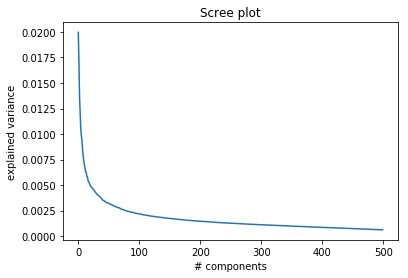

In [59]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree plot');

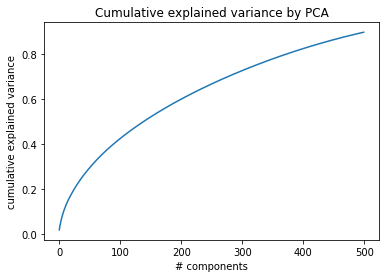

In [60]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulative explained variance by PCA');

In [61]:
clf = SGDClassifier(loss='hinge', penalty='l2',
                                    alpha=1e-3, class_weight='balanced')

clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_val_pca)
print(classification_report(y_val, y_pred))

                                precision    recall  f1-score   support

            Administrative Law       0.40      1.00      0.57         2
Alternative Dispute Resolution       0.75      1.00      0.86         3
                   Arbitration       0.00      0.00      0.00         1
           Banking And Finance       0.20      1.00      0.33         1
                    Civil Laws       0.00      0.00      0.00         2
               Civil Procedure       0.63      0.63      0.63        27
                   Company Law       1.00      0.83      0.91         6
                  Constitution       0.38      0.60      0.46         5
             Contempt Of Court       1.00      1.00      1.00         1
                      Contract       1.00      0.33      0.50         3
         Cooperative Societies       1.00      1.00      1.00         1
                 Criminal Laws       0.80      0.40      0.53        10
            Criminal Procedure       0.67      0.71      0.69  

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
xgb = XGBClassifier()

clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_val_pca)
print(classification_report(y_val, y_pred))

## Oversampled Models

In [63]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [64]:
sm = SMOTE(random_state=2, k_neighbors=1)
X_train_smote, y_train_smote = sm.fit_sample(X_train_tfidf, y_train)

## Naive Bayes (Oversampled)

In [80]:
clf = SGDClassifier(loss='hinge', penalty='l2',
                                    alpha=1e-3, class_weight='balanced')

clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_val_tfidf)
print(classification_report(y_val, y_pred))

                                precision    recall  f1-score   support

            Administrative Law       0.40      1.00      0.57         2
Alternative Dispute Resolution       0.75      1.00      0.86         3
                   Arbitration       0.00      0.00      0.00         1
           Banking And Finance       0.20      1.00      0.33         1
                    Civil Laws       0.00      0.00      0.00         2
               Civil Procedure       0.73      0.41      0.52        27
                   Company Law       0.83      0.83      0.83         6
                  Constitution       0.33      0.60      0.43         5
             Contempt Of Court       1.00      1.00      1.00         1
                      Contract       0.50      0.33      0.40         3
         Cooperative Societies       1.00      1.00      1.00         1
                 Criminal Laws       0.78      0.70      0.74        10
            Criminal Procedure       0.82      0.64      0.72  

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## SGD (Oversampled)

In [70]:
clf = SGDClassifier(loss='hinge', penalty='l2',
                                    alpha=1e-3, class_weight='balanced')

clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_val_tfidf)
print(classification_report(y_val, y_pred))

                                precision    recall  f1-score   support

            Administrative Law       0.40      1.00      0.57         2
Alternative Dispute Resolution       0.75      1.00      0.86         3
                   Arbitration       0.00      0.00      0.00         1
           Banking And Finance       0.17      1.00      0.29         1
                    Civil Laws       0.00      0.00      0.00         2
               Civil Procedure       0.80      0.44      0.57        27
                   Company Law       0.83      0.83      0.83         6
                  Constitution       0.33      0.60      0.43         5
             Contempt Of Court       1.00      1.00      1.00         1
                      Contract       0.50      0.33      0.40         3
         Cooperative Societies       1.00      1.00      1.00         1
                 Criminal Laws       0.70      0.70      0.70        10
            Criminal Procedure       0.75      0.64      0.69  

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Oversampled with SVD

In [72]:
svd = TruncatedSVD(700)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_smote)
X_val_lsa = lsa.transform(X_val_tfidf)

explained_variance = svd.explained_variance_ratio_.sum()
print("  Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

  Explained variance of the SVD step: 99%


In [74]:
clf = SGDClassifier(loss='hinge', penalty='l2',
                                    alpha=1e-3, class_weight='balanced')

clf.fit(X_train_lsa, y_train_smote)
y_pred = clf.predict(X_val_lsa)
print(classification_report(y_val, y_pred))

                                precision    recall  f1-score   support

            Administrative Law       0.40      1.00      0.57         2
Alternative Dispute Resolution       0.75      1.00      0.86         3
                   Arbitration       0.00      0.00      0.00         1
           Banking And Finance       0.17      1.00      0.29         1
                    Civil Laws       0.00      0.00      0.00         2
               Civil Procedure       0.79      0.41      0.54        27
                   Company Law       1.00      0.83      0.91         6
                  Constitution       0.33      0.60      0.43         5
             Contempt Of Court       1.00      1.00      1.00         1
                      Contract       0.33      0.33      0.33         3
         Cooperative Societies       1.00      1.00      1.00         1
                 Criminal Laws       0.70      0.70      0.70        10
            Criminal Procedure       0.82      0.64      0.72  

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## LSTM

In [98]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [113]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_posts = X_train
train_tags = y_train

test_posts = X_val
test_tags = y_val

max_words = 10000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 10

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 644 samples, validate on 72 samples
Epoch 1/10
644/644 [==============================] - 33s 52ms/step - loss: 3.0216 - acc: 0.2438 - val_loss: 2.0387 - val_acc: 0.4861
Epoch 2/10
644/644 [==============================] - 17s 26ms/step - loss: 1.1360 - acc: 0.7174 - val_loss: 1.6696 - val_acc: 0.5417
Epoch 3/10
644/644 [==============================] - 16s 25ms/step - loss: 0.3921 - acc: 0.9317 - val_loss: 1.5763 - val_acc: 0.5694
Epoch 4/10
644/644 [==============================] - 24s 38ms/step - loss: 0.1578 - acc: 0.9829 - val_loss: 1.5319 - val_acc: 0.6111
Epoch 5/10
644/644 [==============================] - 26s 40ms/step - loss: 0.0652 - acc: 0.9984 - val_loss: 1.4675 - val_acc: 0.6389
Epoch 6/10
644/644 [==============================] - 28s 44ms/step - loss: 0.0460 - acc: 0.9969 - val_loss: 1.4754 - val_acc: 0.6250
Epoch 7/10
644/644 [==============================] - 30s 46ms/step - loss: 0.0406 - acc: 0.9984 - val_loss: 1.4795 - val_acc: 0.6389
Epoch 8/10
644/64

In [116]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

179/179 [==============================] - 0s 589us/step
Test accuracy: 0.5363128488290243


In [125]:
model.predict_classes(x_test)

array([ 5, 35, 19, 33, 35, 34,  0,  5, 21,  6, 12, 30,  6, 33,  5,  5, 33,
       33,  5, 11, 13,  5,  5,  5, 35, 34,  1, 21, 12, 30, 30,  5, 30, 35,
        6, 11,  5, 21, 21,  5,  5, 30,  5, 19, 12, 21,  6, 26, 12,  5, 12,
        5, 33, 33,  5, 35,  7,  5,  5, 30, 12,  5, 32, 35,  6, 21, 33,  5,
       35, 21, 35, 30, 26, 11, 21, 30,  5, 30, 33,  7, 30, 30,  6, 21,  5,
       21,  5,  5, 12,  5, 32,  5,  5, 12, 33, 33, 11, 11, 13,  5,  5,  5,
       33, 33,  5, 12, 30,  5, 21, 12, 33, 21,  5, 11,  5, 21, 35,  5,  5,
       12, 12, 33, 35, 11, 21, 11, 12, 35, 35, 12,  5, 35,  5, 13,  5, 21,
       33, 30, 21, 12, 30, 35,  5,  7,  5, 30, 30,  5,  5, 21, 11, 12, 35,
        5, 21, 30, 21, 33, 35, 30,  5, 30,  9, 30,  9,  5, 21, 12, 34, 33,
        5,  5, 35, 21,  5,  5,  5, 33, 26])

In [133]:
y_pred = encoder.inverse_transform(model.predict_classes(x_test))


In [135]:
print(classification_report(y_val, y_pred))

                                precision    recall  f1-score   support

            Administrative Law       0.00      0.00      0.00         2
Alternative Dispute Resolution       1.00      0.33      0.50         3
                   Arbitration       0.00      0.00      0.00         1
           Banking And Finance       0.00      0.00      0.00         1
                    Civil Laws       0.00      0.00      0.00         2
               Civil Procedure       0.39      0.74      0.51        27
                   Company Law       0.67      0.67      0.67         6
                  Constitution       0.33      0.20      0.25         5
             Contempt Of Court       0.00      0.00      0.00         1
                      Contract       0.00      0.00      0.00         3
         Cooperative Societies       0.00      0.00      0.00         1
                 Criminal Laws       0.56      0.50      0.53        10
            Criminal Procedure       0.59      0.71      0.65  

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
